In [53]:
import pandas as pd
import json

import psycopg2
conn = psycopg2.connect(host='ec2-107-20-166-28.compute-1.amazonaws.com',
                        user='rbhciitblovwew',
                        database='db274el0c49tdu')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={"figure.figsize": (16, 9)})
sns.set(style="whitegrid")

In [3]:
query = """
SELECT
user_id
, (data -> 'activities-heart' ->> 0)::json ->> 'dateTime' as heart_day
, json_array_elements(data -> 'activities-heart-intraday' -> 'dataset') ->> 'value' as bpm
, json_array_elements(data -> 'activities-heart-intraday' -> 'dataset') ->> 'time' as tme
FROM activity_journals
WHERE activity_type = 'heart_rate'
  AND archived = FALSE
"""
heart_journals = pd.read_sql(query, conn)

In [4]:
heart_journals.head()

,user_id,heart_day,bpm,tme,activity_type
0,1,2016-12-25,55,00:00:00,heart_rate
1,1,2016-12-25,54,00:01:00,heart_rate
2,1,2016-12-25,53,00:02:00,heart_rate
3,1,2016-12-25,53,00:03:00,heart_rate
4,1,2016-12-25,54,00:04:00,heart_rate


In [5]:
query = """
SELECT
user_id
, (data -> 'activities-steps' ->> 0)::json ->> 'dateTime' as step_day
, journal_date
, json_array_elements(data -> 'activities-steps-intraday' -> 'dataset') ->> 'value' as steps
, json_array_elements(data -> 'activities-steps-intraday' -> 'dataset') ->> 'time' as tme
FROM activity_journals
WHERE activity_type = 'steps'
  AND archived = FALSE
"""
step_journals = pd.read_sql(query, conn)
step_journals.head()

,user_id,step_day,journal_date,steps,tme
0,1,2016-12-25,2016-12-25,0,00:00:00
1,1,2016-12-25,2016-12-25,0,00:01:00
2,1,2016-12-25,2016-12-25,0,00:02:00
3,1,2016-12-25,2016-12-25,0,00:03:00
4,1,2016-12-25,2016-12-25,0,00:04:00


In [25]:
query = """
WITH step_data AS (
    SELECT
    user_id
    , (data -> 'activities-steps' ->> 0)::json ->> 'dateTime' as step_day
    , json_array_elements(data -> 'activities-steps-intraday' -> 'dataset') ->> 'value' as steps
    , json_array_elements(data -> 'activities-steps-intraday' -> 'dataset') ->> 'time' as tme
    FROM activity_journals
    WHERE activity_type = 'steps'
      AND archived = FALSE
),
heart_data AS (
    SELECT
    user_id
    , (data -> 'activities-heart' ->> 0)::json ->> 'dateTime' as heart_day
    , json_array_elements(data -> 'activities-heart-intraday' -> 'dataset') ->> 'value' as bpm
    , json_array_elements(data -> 'activities-heart-intraday' -> 'dataset') ->> 'time' as tme
    FROM activity_journals
    WHERE activity_type = 'heart_rate'
      AND archived = FALSE
)
SELECT
  sd.user_id AS user_id
 , sd.steps::INT AS steps
 , hd.bpm::INT as bpm
 , hd.heart_day as journal_date
 , CONCAT(sd.step_day, ' ', sd.tme)::TIMESTAMP AS step_dttm
 , CONCAT(hd.heart_day, ' ', hd.tme)::TIMESTAMP AS heart_dttm
FROM step_data AS sd
    JOIN heart_data AS hd ON hd.heart_day = sd.step_day
        AND hd.tme = sd.tme
        AND hd.user_id = sd.user_id
"""
comb_journals = pd.read_sql(query, conn, parse_dates=['step_dttm', 'heart_dttm', 'journal_date'])
comb_journals

,user_id,steps,bpm,journal_date,step_dttm,heart_dttm
0,1,0,55,2016-12-25,2016-12-25 00:00:00,2016-12-25 00:00:00
1,1,0,54,2016-12-25,2016-12-25 00:01:00,2016-12-25 00:01:00
2,1,0,53,2016-12-25,2016-12-25 00:02:00,2016-12-25 00:02:00
3,1,0,53,2016-12-25,2016-12-25 00:03:00,2016-12-25 00:03:00
4,1,0,54,2016-12-25,2016-12-25 00:04:00,2016-12-25 00:04:00
5,1,0,58,2016-12-25,2016-12-25 00:05:00,2016-12-25 00:05:00
6,1,0,63,2016-12-25,2016-12-25 00:06:00,2016-12-25 00:06:00
7,1,0,56,2016-12-25,2016-12-25 00:07:00,2016-12-25 00:07:00
8,1,0,58,2016-12-25,2016-12-25 00:08:00,2016-12-25 00:08:00
9,1,0,54,2016-12-25,2016-12-25 00:09:00,2016-12-25 00:09:00


In [22]:
# a little verification for sanity check
comb_journals.describe()

,user_id,steps,bpm
count,5967.0,5967.000000,5967.000000
mean,1.0,4.586895,60.998659
std,0.0,16.097053,12.150967
min,1.0,0.000000,41.000000
25%,1.0,0.000000,52.000000
50%,1.0,0.000000,60.000000
75%,1.0,0.000000,68.000000
max,1.0,114.000000,124.000000


In [45]:
comb_journals[['bpm', 'steps']].rolling(5).mean().head()

,bpm,steps
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,53.8,0.0


In [29]:
comb_journals.groupby('journal_date')[['steps', 'bpm']].sum()

,steps,bpm
journal_date,,
2016-12-25,5756,81859
2016-12-26,7718,86941
2016-12-27,7224,86981
2016-12-28,6549,83552
2016-12-29,123,24646


## Explore

In [35]:
comb_journals[['bpm', 'steps']].quantile([0.9, 0.95, 0.99])

,bpm,steps
0.90,76.0,11.0
0.95,81.0,26.0
0.99,102.0,100.0


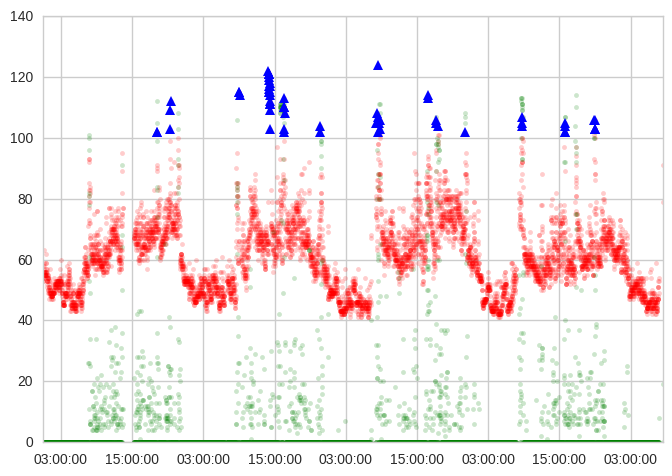

In [60]:
plt.plot(comb_journals['heart_dttm'], comb_journals['bpm'], 'r.', alpha=0.2)
plt.plot(comb_journals['heart_dttm'], comb_journals['steps'], 'g.', alpha=0.2)
plt.plot(extreme_heart['heart_dttm'], extreme_heart['bpm'], 'b^')
plt.show()

In [65]:
extreme_heart = comb_journals.copy()
extreme_heart = extreme_heart[ extreme_heart['bpm'] >= extreme_heart['bpm'].quantile(0.95) ]

extreme_heart['beats_step_ratio'] = extreme_heart.apply( lambda eh: eh['bpm'] / (eh['steps'] + 1), axis=1 ) # +1 avoid div by zero problems
extreme_heart.describe()

,user_id,steps,bpm,beats_step_ratio
count,317.0,317.000000,317.000000,317.000000
mean,1.0,41.416404,91.476341,31.918368
std,0.0,41.829485,10.722783,42.670710
min,1.0,0.000000,81.000000,0.723214
25%,1.0,0.000000,83.000000,1.083333
50%,1.0,26.000000,88.000000,3.000000
75%,1.0,84.000000,98.000000,82.000000
max,1.0,114.000000,124.000000,122.000000


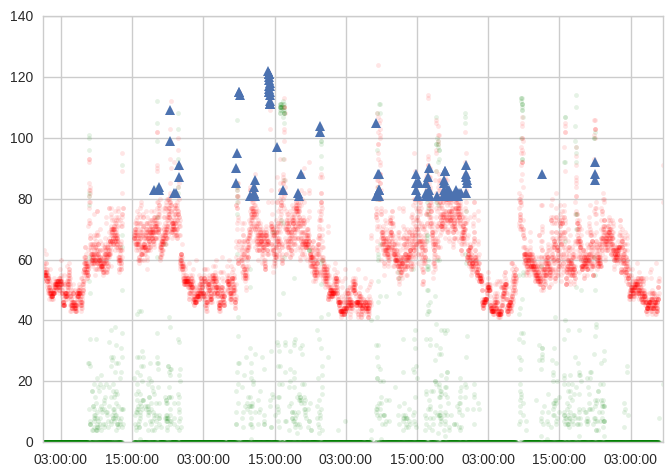

In [68]:
high_ratio = extreme_heart[ extreme_heart['beats_step_ratio'] >= extreme_heart['beats_step_ratio'].quantile(0.70) ]

plt.plot(comb_journals['heart_dttm'], comb_journals['bpm'], 'r.', alpha=0.1)
plt.plot(comb_journals['heart_dttm'], comb_journals['steps'], 'g.', alpha=0.1)

plt.plot(high_ratio['heart_dttm'], high_ratio['bpm'], '^')
plt.show()